In [299]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from thefuzz import fuzz
from thefuzz import process

cars = pd.read_csv("./concatenated_data.csv", index_col=0)
del cars["description"]
cars.columns=['brand', 'model', 'price', 'mileage', 'year', 'location',
'date_added', 'body_type', 'fuel', 'power', 'transmission', 'color',
'price_new', 'engine_size']
cars.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9437 entries, 0 to 5880
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   brand         9411 non-null   object 
 1   model         9411 non-null   object 
 2   price         9432 non-null   float64
 3   mileage       9411 non-null   float64
 4   year          9411 non-null   object 
 5   location      9421 non-null   object 
 6   date_added    3336 non-null   object 
 7   body_type     9191 non-null   object 
 8   fuel          9411 non-null   object 
 9   power         9411 non-null   object 
 10  transmission  9411 non-null   object 
 11  color         9400 non-null   object 
 12  price_new     1955 non-null   float64
 13  engine_size   5855 non-null   object 
dtypes: float64(3), object(11)
memory usage: 1.1+ MB


# Overview

In [300]:
cars.describe()

,price,mileage,price_new
count,9.432000e+03,9.411000e+03,1955.000000
mean,3.309366e+07,2.361327e+12,171507.106905
std,1.645900e+09,1.619689e+14,136366.008481
min,-1.000000e+00,-2.200000e+05,29510.000000
25%,8.000000e+03,2.400000e+04,79990.000000
50%,3.300000e+04,1.010000e+05,136480.000000
75%,5.992500e+04,1.800000e+05,215000.000000
max,1.111111e+11,1.111111e+16,908000.000000


In [301]:
def summary_statistics(dataset):
    print(' summary statistics')
    mean = np.round(np.mean(dataset), 2)
    median = np.round(np.nanmedian(dataset), 2)
    min_value = np.round(dataset.min(), 2)
    max_value = np.round(dataset.max(), 2)
    q1 = np.round(dataset.quantile(0.25), 2)
    q3 = np.round(dataset.quantile(0.75), 2)
    # Interquartile range
    iqr = np.round(q3 - q1, 2)
    print('Min: %s' % min_value)
    print('Mean: %s' % mean)
    print('Max: %s' % max_value)
    print('25th percentile: %s' % q1)
    print('Median: %s' % median)
    print('75th percentile: %s' % q3)
    print('Interquartile range (IQR): %s' % iqr)
    

# Numercal Data cleaning

 summary statistics
Min: -1.0
Mean: 33093662.93
Max: 111111111111.0
25th percentile: 8000.0
Median: 33000.0
75th percentile: 59925.0
Interquartile range (IQR): 51925.0


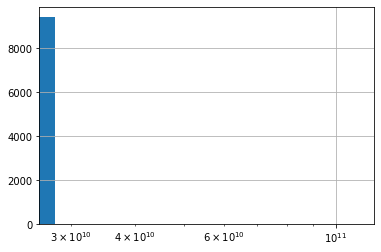

In [302]:
summary_statistics(cars['price'])
cars["price"].hist(bins=4)
plt.xscale('log')
plt.show()

price -> abs(price)
If price is 0 -> price = nan



In [303]:


cars["price"] = abs(cars["price"])
price_is_0 = cars["price"] == 0
cars.loc[price_is_0, "price"] = np.nan



If price over 1_000_000 -> price = nan

In [304]:

price_over_1000000 = cars["price"] >= 1e8
cars.loc[price_over_1000000, "price"] = np.nan


If price less than 500 -> price *= 1000


        brand    model  year   mileage  price
2496      BMW       X6  2008  260000.0   98.0
4444      BMW       X6  2008  260000.0   98.0
5731  Peugeot      301  2014     226.0   97.0
2550     Ford     Kuga  2021   10000.0   97.0
4498     Ford     Kuga  2021   10000.0   97.0
...       ...      ...   ...       ...    ...
4178  Renault       R5  1980     580.0    2.0
5415    Isuzu  Trooper  1990      55.0    2.0
1077  Renault   Symbol  2015  200000.0    2.0
1945  Renault   Symbol  2015  200000.0    2.0
3893  Renault   Symbol  2015  200000.0    2.0

[758 rows x 5 columns]


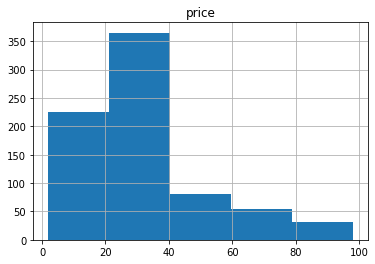

In [329]:

print(cars.loc[(cars["price"] >1) & (cars["price"] <100),["brand","model","year","mileage","price"]].sort_values(by=["price","year"], ascending=[False,True]))
cars.loc[(cars["price"] >1) & (cars["price"] <100),["price","year"]].hist(bins=5)
plt.show()
# price_less_than_1000 = cars["price"] <= 500
# cars.loc[price_less_than_1000, "price"] *= 1000


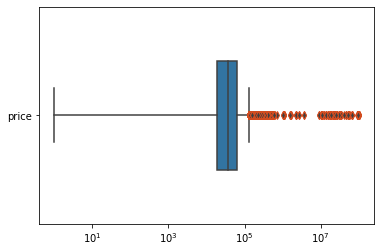

In [306]:

ax = sns.boxplot(data=cars[["price"]],width=0.5,orient='h', flierprops=dict(markeredgecolor="#D94D1F"))
plt.xscale('log')
plt.show()

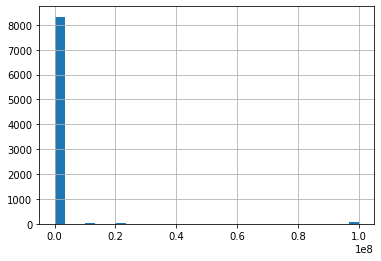

In [307]:
cars["price"].hist(bins=30)
# plt.xscale('log')
plt.show()

Eliminating outliers

In [318]:
def eliminate_outilers_z_score(df,column,threshold=4):
    mean = np.mean(df[column])
    std = np.std(df[column])
    outliers= abs((df[column]-mean)/std)> threshold
    df.loc[outliers,column]=np.nan

In [314]:
def eliminate_outilers_IQR(df,column):
    q1 = np.percentile(df.loc[df[column].notna(), column], 25)
    q3 = np.percentile(df.loc[df[column].notna(), column], 75)

    iqr = q3 - q1

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers= (df[column ] > upper_bound)| (df[column ] < lower_bound)
    df.loc[outliers,column]=np.nan



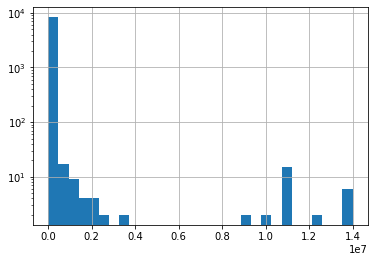

 summary statistics
Min: 1.0
Mean: 91374.36
Max: 14000000.0
25th percentile: 18000.0
Median: 35000.0
75th percentile: 62500.0
Interquartile range (IQR): 44500.0


In [315]:
cars["price"].hist(bins=30)
plt.yscale('log')
plt.show()
summary_statistics(cars["price"])


In [326]:

eliminate_outilers_IQR(cars,"price")

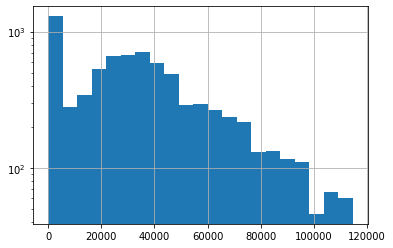

 summary statistics
Min: 1.0
Mean: 35447.7
Max: 114500.0
25th percentile: 16000.0
Median: 32500.0
75th percentile: 51000.0
Interquartile range (IQR): 35000.0


In [327]:
cars["price"].hist(bins=int((109000.0-670.0)/5_000))
plt.yscale('log')
plt.show()
summary_statistics(cars["price"])


In [ ]:
cars.loc[cars["price"] > 400_000]


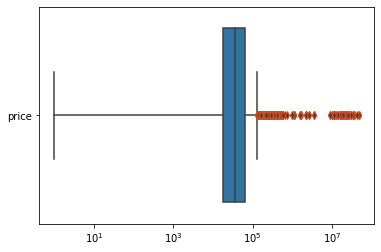

In [287]:
sns.boxplot(data=cars[["price"]], orient="h", flierprops=dict(markeredgecolor="#D94D1F"))
plt.xscale('log')

plt.show()


kilometrage -> abs(kilometrage)

In [ ]:

cars["mileage"] = abs(cars["mileage"])


If mileage < 10 -> mileage = nan

In [ ]:

mileage_less_than_10 = cars["mileage"] < 10
cars.loc[mileage_less_than_10, "mileage"] = np.nan


If mileage <= 1000 -> mileage *= 1000

In [ ]:

mileage_less_than_1000 = cars["mileage"] <= 1000
cars.loc[mileage_less_than_1000, "mileage"] *= 1000

If mileage >= 1 000 000 -> mileage = nan

In [ ]:

mileage_over_1000000 = cars["mileage"] >= 1000000
cars.loc[mileage_over_1000000, "mileage"] = np.nan


# String formatting 

Applying str.title() to each column


In [ ]:

for col in cars.columns:
    if cars[col].dtype == "object":
        cars[col] = cars[col].str.title()


## location

Exploring the values of "location" column


In [ ]:

location_values = cars["location"].unique()
print(location_values, len(location_values))


Unify and fix the values of the "location" column


In [ ]:

my_dict = {
    "Béja": "Beja",
    "La Manouba": "Manouba",
    "Gabès": "Gabes",
    "Médenine": "Medenine",
    "Kébili": "Kebili",
}
cars.replace({"location": my_dict}, inplace=True)


## color

In [ ]:
#specifying the field datatype
cars.color=cars.color.astype(str)
# Exploring the values of the "color" column
colors = cars["color"].unique()
print(colors, len(colors))
len(cars[cars["color"].isna()])


In [ ]:
#get all the words that match "gris"
matches = process.extract("gris", colors, limit=20, scorer=fuzz.token_sort_ratio)
#take a look at them to choose min_ratio
matches

In [ ]:
colors_gris = ["gris" if c.lower().startswith("gris") else c for c in colors]

colors_gris=[c[:-4] if c.lower().endswith("gris")  else c for c in colors_gris]
colors_gris
matches = process.extract("Gris a", colors, limit=30, scorer=fuzz.token_sort_ratio)
score = fuzz.token_sort_ratio("gris ", "Gris Anthracite")
print(score)
matches

In [ ]:
def replace_matches_in_column(df, column, string_to_match, min_ratio = 47):
    # get a list of unique strings
    strings = df[column].unique()
    
    # get the top 10 closest matches to our input string
    matches = process.extract(string_to_match, strings, 
                                         limit=10, scorer=fuzz.token_sort_ratio)

    # only get matches with a ratio > 90
    close_matches = [matches[0] for matches in matches if matches[1] >= min_ratio]

    # get the rows of all the close matches in our dataframe
    rows_with_matches = df[column].isin(close_matches)

    # replace all rows with close matches with the input matches 
    df.loc[rows_with_matches, column] = string_to_match
    
    # let us know the function's done
    print("All done!")
    print(strings, len(strings))

In [ ]:

def replace_colors(df,column, color):
    shades= [c for c in column if c.lower().strip().startswith(color) ]
    rows_with_matches=df["color"].isin(shades)
    df.loc[rows_with_matches, "color"]=color
     

In [ ]:
replace_colors(cars,colors,"gris")
replace_colors(cars,colors,"bleu")
replace_colors(cars,colors,"blanc")
replace_colors(cars,colors,"vert")
replace_colors(cars,colors,"rouge")
replace_colors(cars,colors,"noir")


In [ ]:
colors = cars["color"].unique()
print(colors, len(colors))
len(cars[cars["color"].isna()])

Unify and fix the values of the "color" column


In [ ]:
my_dict = {
    "Argent": "Gris",
    "Feuille D'Argent": "Gris",
    "Titanium": "Gris",
    "Miel": "Doré",
    "Champagne": "Jaune",
    "Grenadine": "Rouge",
    "Rouge Bordeaux": "Rouge",
    "Mauve Gris": "Mauve",
    "Aubergine": "Violet",
    "Maran": "Marron",
    "Corail": "Orange",
}
cars.replace({"color": my_dict}, inplace=True)
colors = cars["color"].unique()
print(colors, len(colors))
len(cars[cars["color"].isna()])


In [ ]:

# my_dict = {
#     "Blanche": "Blanc",
#     "Blanc Cristal": "Blanc",
#     "Grise": "Gris",
#     "Gris Métallisé": "Gris",
#     "Grise Metalisee": "Gris",
#     "Grise Métallisée": "Gris",
#     "Gris Clair Métallisé": "Gris",
#     "Gris Foncé": "Gris",
#     "Gris Charbon": "Gris",
#     "Gris Magnetic": "Gris",
#     "Bleu Gris": "Bleu",
#     "Bleu/Gris": "Bleu",
#     "Bleu Roi": "Bleu",
#     "Bleu Métallisée": "Bleu",
#     "Gris Titanium": "Argent",
#     "Gris Titanuim": "Argent",
#     "Gris Argent": "Argent",
#     "Feuille D'Argent": "Argent",
#     "Titanium": "Argent",
#     "Miel": "Jaune",
#     "Champagne": "Jaune",
#     "Grenadine": "Rouge",
#     "Rouge Bordeaux": "Rouge",
#     "Mauve Gris": "Violet",
#     "Aubergine": "Violet",
#     "Noire": "Noir",
#     "Maran": "Marron",
#     "Corail": "Orange",
# }
# cars.replace({"color": my_dict}, inplace=True)


If color is "*****" -> color = nan


In [ ]:

specified_color = cars["color"] == "*****"
cars[specified_color] = np.nan

## model

## brand

## body work

Convert N.D to nan in the "power" column

In [ ]:

power_is_ND = cars["power"] == "N.D"
cars.loc[power_is_ND, "power"] = np.nan

Convert the column "power" to float

In [ ]:

contains_CV = cars["power"].str.contains("C") & cars["power"].notna()
cars.loc[contains_CV, "power"] = cars.loc[contains_CV, "power"].apply(
    lambda string: string.split()[0]
)
cars["power"] = cars["power"].astype(np.float64)


If power > 200 -> power = nan

In [ ]:

power_over_200 = cars["power"] > 200
cars.loc[power_over_200, "power"] = np.nan


Convert the column "engine_size" to float

In [ ]:
contains_symbol = cars["engine_size"].str.contains("[><]") & cars["engine_size"].notna()
cars.loc[contains_symbol, "engine_size"] = cars.loc[contains_symbol, "engine_size"].apply(
    lambda string: string[1:]
)
cars.loc[cars["engine_size"].notna(), "engine_size"] = cars.loc[
    cars["engine_size"].notna(), "engine_size"
].apply(lambda string: string[:-1])
cars["engine_size"] = cars["engine_size"].astype(np.float64)


# Dates

Turn "date_added" column to datetime

In [ ]:

contains_hyphen = cars["year"].str.contains("-") & cars["year"].notna()
cars.loc[contains_hyphen, "year"] = cars.loc[contains_hyphen, "year"].apply(
    lambda string: string.split("-")[1]
)
contains_point = cars["year"].str.contains("[.]") & cars["year"].notna()
cars.loc[contains_point, "year"] = cars.loc[contains_point, "year"].apply(
    lambda string: string.split(".")[-1]
)
cars["year"] = cars["year"].astype(np.float64)

If 10<= year <= 23 -> year += 2000, if 60 <= year -> year += 1900, else year = nan

In [ ]:

year_between_0_and_23 = (cars["year"] >= 10) & (cars["year"] <= 23)
cars.loc[year_between_0_and_23, "year"] += 2000
year_more_than_60 = (cars["year"] >= 60) & (cars["year"] <= 99)
cars.loc[year_more_than_60, "year"] += 1900
correct_year = (cars["year"] >= 1960) & (cars["year"] <= 2023)
cars.loc[~correct_year, "year"] = np.nan


Remove month from year in the "year" column and convert it to float

In [ ]:

cars["date_added"] = pd.to_datetime(cars["date_added"])

# Dropping duplicates

In [ ]:

cars.drop_duplicates(inplace=True)


In [ ]:
cars.to_csv("./new_clean_data.csv")
cars.info()
